In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import numpy as np
import os
import math
import cv2
import sys
import urllib.request as ul
from fr_utils import *
from inception_blocks import *
import tensorflow as tf
from IPython.display import clear_output
from matplotlib import pyplot as plt
from six.moves import cPickle as pickle


%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


img_path = 'http://www.ningmeng68.com/uploadfiles/pictures/project/20160628180615_1562.jpg'
img_path = 'https://intranet.ideawisegroup.com/attachments/download/42513/Joe.jpg'
data = ul.urlopen(img_path).read()
data = np.fromstring(data, np.uint8)
img_data =  cv2.imdecode(data, cv2.IMREAD_COLOR)  
img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)    
plt.imshow(img_data)
plt.show()

In [2]:
feature_dir = 'feature_xml'
xml_default = "haarcascade_frontalface_default.xml"
xml_alt2    = "haarcascade_frontalface_alt2.xml"
xml_alt     = "haarcascade_frontalface_alt.xml"
xml_path    = os.path.join(feature_dir, xml_alt)

def test_cam():
    webcam = cv2.VideoCapture(0)
    ret, frame = webcam.read()    
    print(ret)
    webcam.release()  
    
def plt_show(image, title=''):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title(title)
    plt.imshow(image, cmap='Greys_r')
    plt.show()
    
def cut_faces(image, faces_coord):
    faces = []
    for (x, y, w, h) in faces_coord:
        
        # cut only 70% of the width
        w_rm = int(0.2 * w / 2)
        faces.append(image[y: y + h, x + w_rm: x + w - w_rm])
#         faces.append(image[y: y + h, x: x + w])

        
    return faces

def normalize_intensity(images):
    images_norm = []
    for image in images:
        is_color = len(image.shape) == 3
        if is_color:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images_norm.append(cv2.equalizeHist(image))
    return images_norm

def resize(images, size=(50, 50)):
    images_norm = []
    
    for image in images:
        
        if image.shape < size:
            image_norm = cv2.resize(image, size, interpolation = cv2.INTER_AREA)
        
        else:
            image_norm = cv2.resize(image, size, interpolation = cv2.INTER_CUBIC)
        
        images_norm.append(image_norm)
    
    return images_norm

def normalize_faces(frame, faces_coord, size=(96, 96)):
    faces = cut_faces(frame, faces_coord)
#     faces = normalize_intensity(faces)
    faces = resize(faces, size)
    return faces

def draw_rectangle(image, coords):
    
    color = (150, 150, 0)
    thickness = 8
    
    for (x, y, w, h) in coords:
        w_rm = int(0.2 * w / 2)
#         cv2.rectangle(image, (x + w_rm, y), (x + w - w_rm, y + h), color, thickness)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)

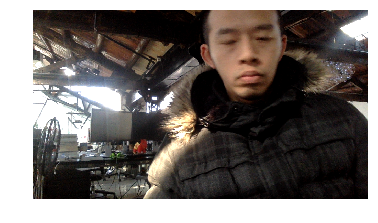

Type: <class 'tuple'>
()
length: 0


In [3]:
# Try to detect the face, What is the returned object?
webcam = cv2.VideoCapture(0)
detector = cv2.CascadeClassifier(xml_path)

_, frame = webcam.read()

scale_factor = 1.2
min_neighbors = 5
min_size = (30, 30)
biggest_only = True
flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
    cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
    cv2.CASCADE_SCALE_IMAGE
    
faces_coord = detector.detectMultiScale(frame, scaleFactor=scale_factor, minNeighbors=min_neighbors, flags=flags, minSize=min_size)
plt_show(frame)

# length means how many faces were detected
print('Type: ' + str(type(faces_coord)))
print(faces_coord)
print('length: ' + str(len(faces_coord)))

webcam.release()

In [4]:
class FaceDetector(object):
    
    def __init__(self, xml_path):
        self.classifier = cv2.CascadeClassifier(xml_path)
        
    def detect(self, image, biggest_only=True):
        scale_factor = 1.2
        min_neighbors = 5
        min_size = (30, 30)
        biggest_only = True
        flags =  cv2.CASCADE_FIND_BIGGEST_OBJECT | \
            cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
            cv2.CASCADE_SCALE_IMAGE
            
        faces_coord = self.classifier.detectMultiScale(image,
                                                      scaleFactor = scale_factor,
                                                      minNeighbors = min_neighbors,
                                                      minSize = min_size,
                                                      flags = flags)
        
        return faces_coord

In [5]:
class VideoCamera(object):
    
    def __init__(self, index=0):
        self.video = cv2.VideoCapture(index)
        self.index = index
        print(self.video.isOpened())
        
    def __del__(self):
        self.video.release()
        
    def get_frame(self, in_grayscale=False):
        _, frame = self.video.read()
        if in_grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return frame

color = (150, 150, 0)
thickness = 8
webcam = VideoCamera()
detector = FaceDetector(xml_path)

try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        if len(faces_coord):
            faces = normalize_faces(frame, faces_coord)
#         plt_show(faces[0])

        for (x, y, w, h) in faces_coord:
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, thickness)
        plt_show(frame)
        
        clear_output(wait=True)

except KeyboardInterrupt:
    print('Live Video Interrupted')
    webcam.video.release()

In [6]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [7]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))    
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))    
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)    
    loss = tf.maximum(tf.reduce_mean(basic_loss), 0.0)
    
    return loss

In [8]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [24]:
# Build or load database
db_file = 'database.pickle'

if not os.path.exists(db_file) :
    print('read from pickle')
    with open(db_file, 'rb') as f:
        database = pickle.load(f)
    
else:
    database = {}
    img_dir = 'images'
    
    # show original pic
    for img_path in os.listdir(img_dir):        
        
        full_path = os.path.join(img_dir, img_path)
        
        # if it's a directory and not a .ipynb_checkpoints
        if os.path.isdir(full_path) and img_path[0] != '.':      
            print('Processing ' + img_path)
            for sub_img_path in os.listdir(full_path):
                idx = img_path + '-' + sub_img_path.split('.')[0]                
                database[idx] = img_path_to_encoding(os.path.join(full_path, sub_img_path), FRmodel)        
        
        if img_path[0:3] == 'tmp' or (img_path[-3:] != 'jpg' and img_path[-3:] != 'png'): 
            continue    
        img_idx = img_path.split('.')    
        print('Processing ' + img_idx[0])
        origin_img = cv2.imread(full_path)
        detector = FaceDetector(xml_path)
        faces_coord = detector.detect(origin_img)
        if len(faces_coord) > 0:
            norm_pic = normalize_faces(origin_img, faces_coord)
            database[img_idx[0].lower()] = img_to_encoding(norm_pic[0], FRmodel)

    print('Total ' + str(len(database)))        


    try:
        with open(db_file, 'wb') as f:
            pickle.dump(database, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to ', db_file, ':', e)        

Processing David
Processing BaohuaCai
Processing Luke
Processing Tim
Processing Arki
Processing Tianwen
Processing VickiXu
Processing XiaohongWu
Processing RobertDreyer
Processing DenizDurmus
Processing Grace
Processing Ken
Processing CookXue
Processing Oscar
Processing Aaron
Processing mom
Processing RodericLiu
Processing KevinPan
Processing BennMa
Processing JerryGu
Processing TinaXia
Processing Ying
Processing Jethro
Processing BlaiseIranyumviye
Processing J-Pts
Processing Dean-Ding
Processing LeoZhang
Processing Damon
Processing eric-zheng
Processing Gesion-Wan
Processing Valerie
Processing Michelle
Processing SebastianKlier
Processing JuliusXue
Processing Archer
Processing Alicia-230
Processing Devin-Zhang
Processing Doto
Processing joe
Processing Yaan
Processing BillyShen
Processing doto
Processing fan
Processing FanChen
Processing Leon
Processing TomEdme
Processing CarinaSchafer
Processing Benjamin
Processing Seven
Processing ShengJiang
Processing Evonne
Processing lina
Processi

In [10]:
def verify(image, identity, database, model):
    
    threshold = 0.6
    
    encoding = img_to_encoding(image, model)
    
    dist = np.linalg.norm(database[identity] - encoding)
    
    if dist < threshold:
        print("It's " + str(identity) + ", welcome home!")
        pass_auth = True
    else:
        print("It's not " + str(identity) + ", please go away")
        pass_auth = False
        
#     print(dist, pass_auth)    
    return dist, pass_auth

In [11]:
def who_is_it(image, database, model, threshold):
    
    encoding = img_to_encoding(image, model)
    
    min_dist = 100
    
    identity = 'unknown'
    
    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(db_enc - encoding)

        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > threshold:
#         print("Unknown.")
        identity = 'unknown'
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

# Detect

In [25]:
color = (66, 53, 243)
thickness = 6
font_size = 2
threshold = 0.35
auth = False
webcam = VideoCamera()
detector = FaceDetector(xml_path)

cv2.namedWindow('Face Detection', cv2.WINDOW_AUTOSIZE)

try:
    while True:
                
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        if len(faces_coord):
            faces = normalize_faces(frame, faces_coord)            
            clear_output(wait=True)
            draw_rectangle(frame, faces_coord)
    
    
            for i, face in enumerate(faces):
                min_dist, identity = who_is_it(face, database, FRmodel, threshold)   
                
                text = ''
                
                if min_dist < threshold:
                    
                    identity = identity.split('-')[0]
                    
                    text = identity.upper()                                        
#                     text = identity + ' - ' + str(min_dist)
                
                
                cv2.putText(frame, text, \
                            (faces_coord[i][0], faces_coord[i][1]), \
                            cv2.FONT_HERSHEY_SIMPLEX, font_size, color, thickness)

#         plt_show(faces[0])
        cv2.imshow('FD', frame)
        
        if cv2.waitKey(40) & 0xFF == 27:
            webcam.video.release()
            cv2.destroyAllWindows()
            break
            
except KeyboardInterrupt:
    print('Live Video Interrupted')
    webcam.video.release()

In [13]:
try:
    webcam.video.release()
except:
    print('no webcam is activated')

# Create data image

In [23]:
folder = 'images/' + input('Person: ').lower() # input name
cv2.namedWindow('Please show different facial expression', cv2.WINDOW_AUTOSIZE)
webcam = VideoCamera()

# if dir doesn't exist, create one
if not os.path.exists(folder):
    os.mkdir(folder)
    counter = 0

# if dir exists, set counter 1 more than the one exists    
else:    
    # format: 0.jpg
    counter = max([int(img.split('.')[0]) for img in os.listdir(folder)]) + 1

timer = 0
pictures_to_take = 15

while counter < pictures_to_take:
    frame = webcam.get_frame()
    faces_coord = detector.detect(frame)

    if len(faces_coord) and timer % 700 == 50: # every second or so
        faces = normalize_faces(frame, faces_coord) # norm pipeline
        cv2.imwrite(folder + '/' + str(counter) +'.jpg', faces[0])
        plt_show(faces[0], 'Images Saved:' + str(counter))
        clear_output(wait = True) # saved face in notebook
        counter += 1
        print('picture-{}'.format(counter))

    draw_rectangle(frame, faces_coord) # rectangle around face
    cv2.imshow('Py', frame) # live feed in external

    cv2.waitKey(20)
    timer += 50

cv2.destroyAllWindows()
webcam.video.release()

picture-15


In [ ]:
webcam.video.release()